In [24]:
# slient install
!pip install -q -r requirements.txt
!pip install  -q -i https://test.pypi.org/simple/ EuroPy

In [110]:
import os, time
from datetime import datetime
from tqdm.notebook import trange, tqdm
import itertools

import europy
from europy.notebook import load_global_params
from europy.decorator import using_params, bias, data_bias, fairness, accountability, transparency, minimum_functionality, accuracy
from europy.decorator import model_details
from europy.lifecycle import reporting
from europy.lifecycle.reporting import execute_tests

import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, roc_auc_score

from transformers import BertTokenizer

from model import BertClassifier
from transformers import TFBertModel

## TODO: 
- [ ] pull data from a s3 with model details and params
- [x] word cloud and word freq for testing and training data
- [x] Dist. of classes (data bias) (training and testing data)
- [ ] sim between testing and training dist.
- [x] spanish functionality (bias) 
- [ ] accurary test -- confusion matrix
- [ ] min. functionality tests
    - pretrained model doesn't work
    - trained model works on clearly non-toxic comments
    - trained model works on clearly toxic comments


idea: pull in a documented list of 

### Setup

In [4]:
# load global parameters from file
params = load_global_params('params.yml')

========= EuroPy Captured Params: (global) =========
  - global.pre_trained_model: bert-base-uncased
  - global.max_seq_len: 128
  - global.train_percent: 0.1
  - global.batch_size: 32
  - global.num_epochs: 1
  - global.label_cols: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
  - global.test_size: 0.1
  - global.learning_rate: 2e-05


In [5]:
# pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained(
    params['pre_trained_model'],
    do_lower_case=True
)

In [71]:
# load data

submission_df = pd.read_csv('data/submission.csv')
test_labels = pd.read_csv('data/test_labels.csv')

cols_rn = {}
for label in params['label_cols']:
    cols_rn[label] = label+'_gt'
test_labels.rename(columns=cols_rn, inplace=True)

test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

obscene_words = open("data/obscene_words.txt", "r").readlines()
obscene_words = [w.strip('\n').lower() for w in obscene_words]


# merge generated submission
test_df = test_df.merge(submission_df, on='id').dropna()
test_df = test_df.merge(test_labels, on='id').dropna()

## Test: Data

In [137]:
@accuracy()
def precision(df, pos=0.5, ep=1e-6):
    tps = {}
    fps = {}

    for i, row in df.iterrows():
        for label in params['label_cols']:
            if row[label+'_gt'] == 1.0 and row[label] >= pos: 
                tps[label] = tps.get(label, 0) + 1
            elif row[label+'_gt'] <= 0.0 and row[label] > pos:
                fps[label] = fps.get(label, 0) + 1

    precision = []
    for label in params['label_cols']:
        tp = tps.get(label, 0)
        fp = fps.get(label, 0)
        p = {
            'label': label,
            'precision': tp / (tp + fp + ep)
        }
        precision.append(p)
        


    return pd.DataFrame.from_dict(precision)

In [138]:
precision(test_df)

,label,precision
0,toxic,0.161835
1,severe_toxic,0.133710
2,obscene,0.146496
3,threat,0.247059
4,insult,0.168711
5,identity_hate,0.179073


### Compare common words from training and Testing Data

In [5]:
def bleep(w, obscene_words):
    if w in obscene_words:
        mask = len(w[1:-1]) * '*'
        word_mask = w[0] + mask + w[-1]
        return word_mask
    return w

In [8]:
def generate_word_cloud(df, label, threshold=0.9):
    from wordcloud import WordCloud, STOPWORDS
    
    stopwords = set(STOPWORDS)
    sub_df = df.where(df[label] > threshold).dropna()
    
    comment_words = sub_df.comment_text.to_numpy().flatten().tolist()
    comment_words = " ".join(comment_words).split(" ")
    comment_words = [w.lower() for w in comment_words]
    comment_words = list(filter(lambda w: w.isalpha() and len(w) > 2, comment_words))
    
    # takes too long -- need to optimize
    # comment_words = [bleep(w, obscene_words) for w in comment_words]
    
    if len(comment_words) == 0: return None, comment_words
    
    wc = WordCloud(
        width=800,
        height=800,
        background_color='white',
        stopwords=stopwords,
        min_font_size=10,
        collocations=False
    ).generate(" ".join(comment_words))
    
    return wc, comment_words

@transparency("Word Cloud by Label", 
      "Comparision of word clouds between testing and training data. Includes counts of words used in each")
def classification_word_clouds(train_df, test_df, label_cols=[], threshold=0.8, plots={}):
    num_of_words = {}
    for label in label_cols:
        train_wc, train_words = generate_word_cloud(train_df.copy(), label, threshold=threshold)
        test_wc, test_words = generate_word_cloud(test_df.copy(), label, threshold=threshold)
        
        if train_wc is not None and test_wc is not None:
            
            f = plt.figure(figsize=(24, 12))
            f.add_subplot(1, 2, 1)
            plt.imshow(train_wc)
            f.add_subplot(1,2, 2)
            plt.imshow(test_wc)
            
            plots[label] = plt
        
        num_of_words[label] = {}
        num_of_words[label]['train'] = len(train_words)
        num_of_words[label]['test'] = len(test_words)
    
    return {'threshold': threshold, 'word_counts': num_of_words}
    

In [9]:
execute_tests(clear=True, train_df=train_df, test_df=test_df, label_cols=params['label_cols'])

Execute - Word Cloud by Label (['transparency'])
	PASS
Execute - Testing, Training, and Inference Class Distrubutions (['data-bias'])
	FAIL
========= EuroPy Test Results =========
Report output: file:///home/b/.europy/reports/03122020_213154/report.json
Total Tests: 2
Passing: 1
Failing: 1


,key,description,labels,result,figures,success
0,Word Cloud by Label,Comparision of word clouds between testing and...,[transparency],"{'threshold': 0.8, 'word_counts': {'toxic': {'...","[ReportFigure(\n\ttitle: toxic,\n\tdescription...",True
1,"Testing, Training, and Inference Class Distrub...",None,[data-bias],"[Traceback (most recent call last):\n, File ...",[],False


### Class Distrubutions

In [10]:
def count_classes(df, threshold, label_cols):
    counts = [0] * len(label_cols)
    for i, label in enumerate(label_cols):
        values = df[label].to_list()
        for value in values:
            if value > threshold:
                counts[i] += 1
    return counts
    

@data_bias("Testing, Training, and Inference Class Distrubutions")
def class_dist(train_df, test_df, test_labels_df, label_cols, threshold=0.9, no_class=False, plots={}):    
    train_counts = count_classes(train_df, threshold, label_cols)
    test_pred_counts = count_classes(test_df, threshold, label_cols)
    test_label_counts = count_classes(test_labels_df, threshold, label_cols)
    
    if no_class:
        label_cols.append('None')
        train_counts.append(train_df.shape[0] - sum(train_counts))
        test_pred_counts.append(test_df.shape[0] - sum(test_pred_counts))
        test_label_counts.append(test_labels_df.shape[0] - sum(test_label_counts))
    
    dist_data = {}
    for i, label in enumerate(label_cols):
        dist_data[label] = {}
        dist_data[label]['train_actual'] = train_counts[i]
        dist_data[label]['test_predictions'] = test_pred_counts[i]
        dist_data[label]['test_actuals'] = test_label_counts[i]

    x = np.arange(len(label_cols))  # the label locations
    width = 0.2
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, train_counts, width, label='Train Actual')
    rects2 = ax.bar(x + width, test_pred_counts, width, label='Test Predictions')
    rects3 = ax.bar(x - width, test_label_counts, width, label='Test Actual')
    
    ax.set_ylabel('Count')
    ax.set_title('Counts by Classification')
    ax.set_xticks(x)
    ax.set_xticklabels(label_cols)
    ax.legend()
    
    fig.tight_layout()
   
    plots["Class Distribution"] = plt
    
    return dist_data

{'toxic': {'train_actual': 15294,
  'test_predictions': 17554,
  'test_actuals': 6090},
 'severe_toxic': {'train_actual': 1595,
  'test_predictions': 0,
  'test_actuals': 367},
 'obscene': {'train_actual': 8449,
  'test_predictions': 9520,
  'test_actuals': 3691},
 'threat': {'train_actual': 478, 'test_predictions': 3, 'test_actuals': 211},
 'insult': {'train_actual': 7877,
  'test_predictions': 2995,
  'test_actuals': 3427},
 'identity_hate': {'train_actual': 1405,
  'test_predictions': 83,
  'test_actuals': 712},
 'None': {'train_actual': 124473,
  'test_predictions': 123009,
  'test_actuals': 138666}}

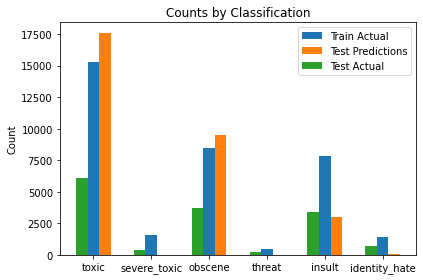

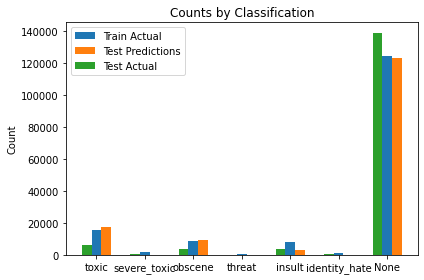

In [21]:
class_dist(train_df, test_df, test_labels, params['label_cols'].copy(), 0.9)
class_dist(train_df, test_df, test_labels, params['label_cols'].copy(), 0.9, no_class=True)

In [22]:
execute_tests(clear=True, train_df=train_df, test_df=test_df, label_cols=params['label_cols'])
# classification_word_clouds(train_df=train_df, test_df=test_df, label_cols=params['label_cols'])

Execute - Word Cloud by Label (['transparency'])
	PASS
Execute - Testing, Training, and Inference Class Distrubutions (['data-bias'])
	FAIL
========= EuroPy Test Results =========
Report output: file:///home/b/dev/EuroPy-Examples/.europy/reports/02122020_232759/report.json
Total Tests: 2
Passing: 1
Failing: 1


,key,description,labels,result,figures,success
0,Word Cloud by Label,Comparision of word clouds between testing and...,[transparency],"{'threshold': 0.8, 'word_counts': {'toxic': {'...","[ReportFigure(\n\ttitle: toxic,\n\tdescription...",True
1,"Testing, Training, and Inference Class Distrub...",None,[data-bias],"[Traceback (most recent call last):\n, File ...",[],False


## Test: Model Inference

In [28]:
# Load model
def load_model(weight_path="models/2020-11-23 08:42_bert.h5"):
    model = BertClassifier(TFBertModel.from_pretrained(params['pre_trained_model']), len(params['label_cols']))
    encoded = tokenizer("init the model", return_tensors='tf')
    model(**encoded)
    model.load_weights(weight_path)
    return model

In [29]:
model = load_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [134]:
def test_model(model, phrases, label_cols=params['label_cols']):
    results = []
    
    for phrase in phrases:
        encoded = tokenizer(phrase, return_tensors='tf')
        output = model(**encoded).numpy()[0]
        result = {}
        result["phrase"] = phrase
        for i in range(len(output)):
            result[label_cols[i]] = f"{output[i]:.2f}"
            

        results.append(result)
    
    return pd.DataFrame.from_dict(results, dtype='float')

### Find Words that Flip Any Sentence

In [171]:
def flip_words(model, base_phrase, threshold=0.9, label_cols=params['label_cols']):
    from random import randint
    phrases = []
    
    for word in obscene_words:
        base_phrase_split = base_phrase.split(" ")
        base_phrase_split.insert(randint(0, len(base_phrase_split)), word)
        phrases.append(" ".join(base_phrase_split))
    
    # phrases.insert(0, base_phrase)
    
    flip_words = [{'label': label, 'words': []} for label in label_cols]

    results = test_model(model, phrases)
    for i, row in results.iterrows():
        record = {}
        obscene_word = obscene_words[i]
        
        for i, label in enumerate(label_cols):
            if row[label] >= threshold:
                flip_words[i]['words'].append(word)
    
    return flip_words

In [173]:
@transparency(
    "Always Toxic words", 
    "identify a set of words that will always flip a non-toxic comment, by class"
)
@bias()
def find_flip_words(model, phrases, label_cols=params['label_cols']):
    all_words = [{'label': label, 'words': []} for label in label_cols]

    for phrase in phrases:
        
        for i in range(len(phrase.split(" "))):
            words_dict = flip_words(model, phrase)
            for i, label in enumerate(label_cols):
                all_words[i]['words'].append(words_dict[i]['words'])

    
    for i, label in enumerate(label_cols):
        all_words[i]['words'] = set.intersection(*map(set,all_words[i]['words']))
    
    return pd.DataFrame.from_dict(all_words)

In [174]:
find_flip_words(model, ["This is really cool, we should try it again sometime"])

,label,words
0,toxic,{yury}
1,severe_toxic,{}
2,obscene,{yury}
3,threat,{}
4,insult,{}
5,identity_hate,{}


### Minimum Functionality

In [177]:
@minimum_functionality("Easily identifable non-toxic phrases", "Phrases should be very low probability in every category")
def non_toxic_identifible_phrases(model):
    nice_phrases = [
        'Hey, it was nice to see you the other day',
        'whoa, I never thought of that',
        'very cool idea',
        'In general I dissagree, but I understand where you are coming from.' ,
        'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod',
        'quia consequuntur magni dolores eos qui ratione voluptatem sequi nesciunt. Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, consectetur, adipisci velit, sed quia non numquam eius modi tempora incidunt ut labore et dolore magnam aliquam quaerat voluptatem. Ut enim ad minima'
    ]
    
    return test_model(model, nice_phrases)

In [178]:
non_toxic_identifible_phrases(model)

,phrase,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"Hey, it was nice to see you the other day",0.00,0.0,0.0,0.0,0.0,0.0
1,"whoa, I never thought of that",0.00,0.0,0.0,0.0,0.0,0.0
2,very cool idea,0.00,0.0,0.0,0.0,0.0,0.0
3,"In general I dissagree, but I understand where...",0.00,0.0,0.0,0.0,0.0,0.0
4,"Lorem ipsum dolor sit amet, consectetur adipis...",0.01,0.0,0.0,0.0,0.0,0.0
5,quia consequuntur magni dolores eos qui ration...,0.01,0.0,0.0,0.0,0.0,0.0


In [190]:
@minimum_functionality("Cleart Toxic Phrases", "Phrases should be high probability in Toxic or Sever-Toxic")
def toxic_identifible_phrases(model):
    toxic_phrases = [
        '',
        '',
        ''
    ]

    return test_model(model, toxic_phrases)

In [191]:
toxic_identifible_phrases(model)

,phrase,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Some people are in such utter darkness that th...,0.30,0.01,0.01,0.07,0.02,0.03
1,Resistance is the most toxic force on the planet.,0.08,0.00,0.00,0.00,0.00,0.00
2,I too am a protestant pedophile,0.79,0.01,0.09,0.01,0.28,0.28


In [186]:
@accountability()
@bias()
@transparency()
def explanation_classification(model):
    phrases = [
        "",
        "",
        "",
        ""
    ]

    return test_model(model, phrases) 

In [187]:
definition_classification(model)

,phrase,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Gay is a term that primarily refers to a homos...,0.55,0.00,0.03,0.01,0.07,0.34
1,"homophobe is a person who hates, fears, or sco...",0.78,0.01,0.06,0.01,0.15,0.47
2,"racial: of, relating to, or based on a race",0.00,0.00,0.00,0.00,0.00,0.00
3,sex: either of the two major forms of individu...,0.00,0.00,0.00,0.00,0.00,0.00


In [139]:
@bias("Context use of the word 'bitch'", "Depending on context and who is using the term, 'bitch can be offensive to empowering'")
def contextual_toxicity(model):
    phrases = [
        "that party was bitchin",
        "Calculus is a bitch",
        "Monday mornings are a bitch",
        "I do everything for my boss. My friends at work tell me that I’M HIS BITCH.",
        "I don’t know what’s wrong with her. She’s being a bitch"
    ]

    return test_model(model, phrases)

In [67]:
contextual_toxicity(model)

{"that party was bitchin'": array([[0.9275135 , 0.0176632 , 0.7729222 , 0.00123135, 0.19012198,
         0.00495247]], dtype=float32),
 'Calculus is a bitch': array([[0.9813549 , 0.09222955, 0.9383471 , 0.00316598, 0.72557735,
         0.00792215]], dtype=float32),
 'Monday mornings are a bitch': array([[0.9818796 , 0.09854642, 0.94699043, 0.00395619, 0.74116457,
         0.00688007]], dtype=float32),
 'I do everything for my boss. My friends at work tell me that I’M HIS BITCH.': array([[0.9544168 , 0.02703715, 0.83275175, 0.00222345, 0.48674878,
         0.00565438]], dtype=float32),
 'I don’t know what’s wrong with her. She’s being a bitch': array([[0.979622  , 0.06659521, 0.92788786, 0.00343673, 0.7367547 ,
         0.00752405]], dtype=float32)}

### Non English Phrases

In [37]:
def test_spanish(model):
    spanish_profanity = [
        'Oye, vete a la mierda.',
        'Eres una idiota por decir algo como esto.',
        'debería ser encarcelado.'
    ]
    
    english_translations = [
        'Hey, fuck you.',
        'you are an idiot for saying something like this.',
        'you should be thrown in jail.'
    ]
    
    spanish = test_model(model, spanish_profanity)
    english = test_model(model, english_translations)
    
    return english, spanish

In [38]:
test_spanish(model)

({'Hey, fuck you.': array([[0.99005544, 0.21496014, 0.9780608 , 0.00860877, 0.7238991 ,
          0.0102467 ]], dtype=float32),
  'you are an idiot for saying something like this.': array([[0.9760799 , 0.04345509, 0.6237471 , 0.00213233, 0.9083487 ,
          0.00822275]], dtype=float32),
  'you should be thrown in jail.': array([[0.76183665, 0.00607371, 0.02203795, 0.05530175, 0.05293843,
          0.02548073]], dtype=float32)},
 {'Oye, vete a la mierda.': array([[0.00577734, 0.00024578, 0.00090808, 0.00014314, 0.00164257,
          0.00036017]], dtype=float32),
  'Eres una idiota por decir algo como esto.': array([[7.7661419e-01, 3.7507727e-03, 8.9357845e-02, 5.1638845e-04,
          3.3845398e-01, 2.9571448e-03]], dtype=float32),
  'debería ser encarcelado.': array([[0.0016301 , 0.00031263, 0.00053541, 0.00016142, 0.00062459,
          0.00028011]], dtype=float32)})

### Current Events

In [42]:
def test_current_events(model):
    toxic_current_events_phrases = [

    ]
    
    return test_model(model, toxic_current_events_phrases)

In [43]:
test_current_events(model)

{'Masks are for the weak, no one should wear them': array([[0.11960711, 0.00157948, 0.00275532, 0.00657639, 0.00883462,
         0.00900453]], dtype=float32),
 'COVID-19 is delibrate attack on America': array([[0.00208451, 0.0002119 , 0.00044149, 0.00014881, 0.0005456 ,
         0.00028069]], dtype=float32),
 'China Virus': array([[0.0133705 , 0.00036899, 0.0007279 , 0.00039251, 0.00107864,
         0.00136582]], dtype=float32)}